In [1]:
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
from pathlib import Path

In [2]:
part_path = Path("part-1")
part_path.mkdir(exist_ok=True)

raw_path = Path(f"{part_path}/raw")
raw_path.mkdir(exist_ok=True)

processed_path = Path(f"{part_path}/processed")
processed_path.mkdir(exist_ok=True)

submission_path = Path(f"{part_path}/submission")
submission_path.mkdir(exist_ok=True)

In [3]:
df_train = pd.read_csv(f"{processed_path}/train-embeddings.csv")
df_test = pd.read_csv(f"{processed_path}/test-embeddings.csv")

In [5]:
features = [
   "size", 
   "size_b", 
   "size_ratio",
   "stars", 
   "stars_b", 
   "stars_ratio",
   "watchers",
   "watchers_b",
   "watchers_ratio",
   "forks", 
   "forks_b", 
   "forks_ratio", 
   "open_issues", 
   "open_issues_b", 
   "issues_ratio",
   "subscribers_count", 
   "subscribers_count_b",  
   "subscribers_ratio",
   "commit_code",
   "commit_code_b",
   "commits_ratio",
   "forked",
   "forked_b",
   "forked_ratio",
   "issue_closed",
   "issue_closed_b",
   "issue_closed_ratio",
   "issue_comment",
   "issue_comment_b",
   "issue_comment_ratio",
   "issue_opened",
   "issue_opened_b",
   "issue_opened_ratio",
   "issue_reopened",
   "issue_reopened_b",
   "issue_reopened_ratio",
   "pull_request_closed",
   "pull_request_closed_b",
   "pull_request_closed_ratio",
   "pull_request_merged",
   "pull_request_merged_b",
   "pull_request_merged_ratio",
   "pull_request_opened",
   "pull_request_opened_b",
   "pull_request_opened_ratio",
   "pull_request_reopened",
   "pull_request_reopened_b",
   "pull_request_reopened_ratio",
   "pull_request_review_comment",
   "pull_request_review_comment_b",
   "pull_request_review_comment_ratio",
   "release_published",
   "release_published_b",
   "release_published_ratio",
   "starred",
   "starred_b",
   "starred_ratio",
   "v_index",
   "v_index_b",
   "v_index_ratio",
   "stars_intersection_v_index",
   "stars_b_intersection_v_index_b",
   "stars_ratio_intersection_v_index_ratio",
   "cosine_similarity",
   "cosine_similarity_b",
   "cosine_ratio",
   "num_dependents",
   "num_dependents_b",
   "dependency_rank",
   "dependency_rank_b",
   "num_dependents_ratio",
]

In [6]:
ratio_features = [feature for feature in features if "ratio" in feature]

In [8]:
X = df_train[ratio_features].to_numpy()
y = df_train["weight_a"].to_numpy()

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np

# Define parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42,
    'n_jobs': -1  # Use all CPU cores
}

# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Train model
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)

    # Make predictions and calculate MSE
    y_pred = rf_model.predict(X_val)
    mse = np.mean((y_val - y_pred) ** 2)
    cv_scores.append(mse)

# Calculate mean and std of MSE scores
cv_scores = np.array(cv_scores)
mean_mse = cv_scores.mean()
std_mse = cv_scores.std()

print(f"Random Forest Cross-validation MSE: {mean_mse:.4f} (+/- {std_mse:.4f})")

Random Forest Cross-validation MSE: 0.0674 (+/- 0.0045)


In [10]:
# Train final model on entire dataset
rf_final = RandomForestRegressor(**rf_params)
rf_final.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [13]:
# Make predictions on test set
X_test = df_test[ratio_features].to_numpy()
test_predictions = rf_final.predict(X_test)
test_predictions = pd.Series(test_predictions).round(6).clip(0)
# test_predictions = pd.Series(test_predictions).round(6).clip(0).apply(lambda x: f"{x:.6f}").astype(float)

<Figure size 1200x800 with 0 Axes>

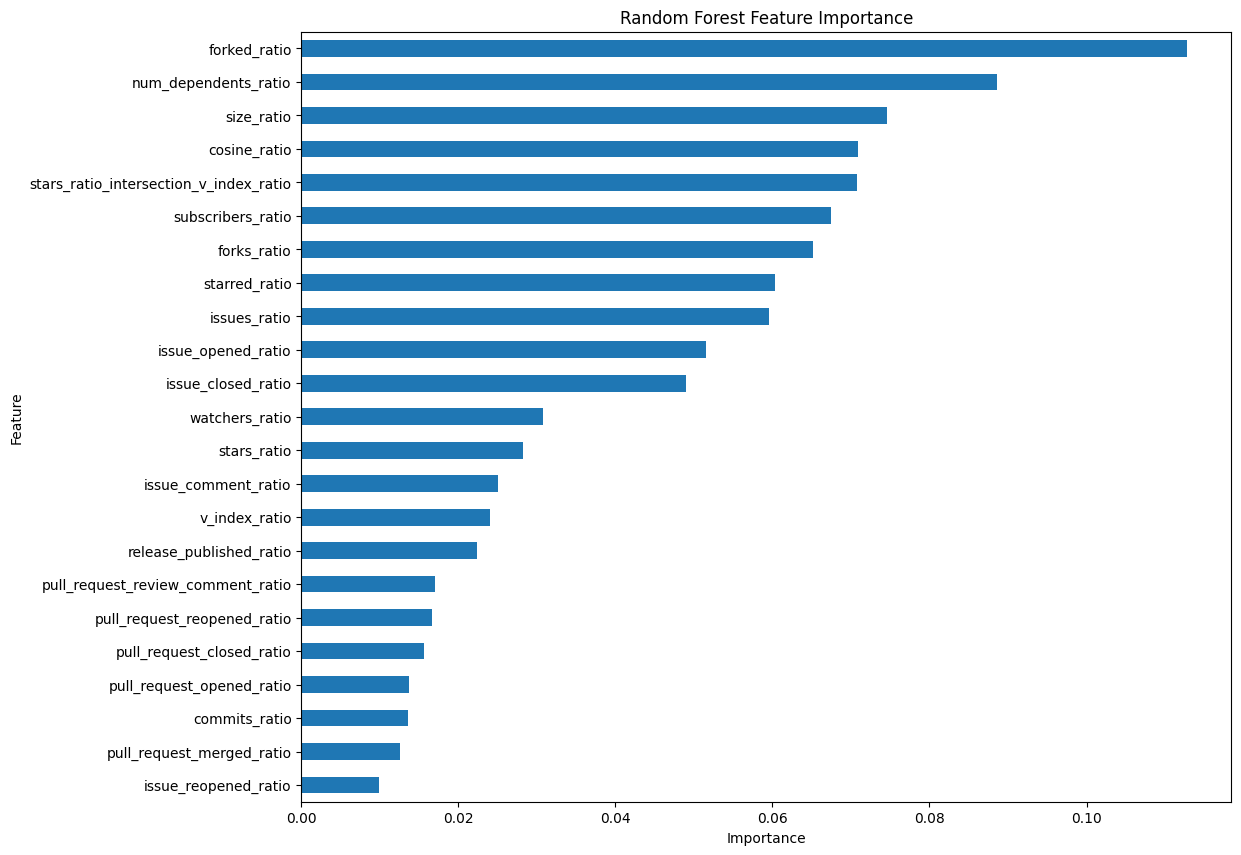

In [15]:
from matplotlib import pyplot as plt
# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': ratio_features,
    'importance': rf_final.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True)
feature_importance.plot.barh(x='feature', y='importance', legend=False, figsize=(12, 10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [32]:
import datetime
# Save submission
submission_path = Path(f"{part_path}/submission")
df_submission = df_test[["id"]].copy()
df_submission["pred"] = test_predictions
filename = f"{submission_path}/rf_submission_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}-mse_{mean_mse:.6f}.csv"
df_submission.to_csv(filename, index=False)
print(f"Saved file: {filename}")

Saved file: part-2/submission/rf_submission_2025-02-07_23-00-58-mse_0.046408.csv


In [33]:
def check_na(df):
    return df[df.isna().sum(axis=1) > 0]

In [34]:
check_na(df_submission)

,id,pred


In [35]:
df_submission.iloc[19]

id      20903.00000
pred        0.96443
Name: 19, dtype: float64